In [131]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import numpy as np

from numpy.random import default_rng
RANDOM_STATE = 2 # random state for default_rng
rng = default_rng(RANDOM_STATE)


import random
#import altair as alt
from tqdm import tqdm
import datetime

# CHECKLIST for Kaggle variant
# USE_ALL_STOCK_IDS False to check then True
# USE_TEST_LOCAL_6_ITEMS must be False else we override the locl test data
# TEST_SIZE must be 0 to get all items
# Check on Kaggle that "internet" is disabled

# CHECKLIST for home variant
# USE_ALL_STOCK_IDS False for fast dev, True for proper testing
# NBR_FOR_SUBSET_OF_STOCK_IDS 4 for quick testing

t1_notebook_start = datetime.datetime.utcnow()

if os.environ.get('USER') == 'ian':
    ENV_HOME = True
    import ipython_memory_usage
    %ipython_memory_usage_start
    USE_ALL_STOCK_IDS = True
    NBR_FOR_SUBSET_OF_STOCK_IDS = 4
    TEST_SIZE = 0.25
    USE_TEST_LOCAL_6_ITEMS = True # robust local testing at home
    #USE_TEST_LOCAL_6_ITEMS = False # robust local testing at home TEMPORARY WHILST DEBUGGING
else:
    ENV_HOME = False
    USE_ALL_STOCK_IDS = False # for KAGGLE on first-upload for a quick test
    TEST_SIZE = 0
    USE_TEST_LOCAL_6_ITEMS = False
    NBR_FOR_SUBSET_OF_STOCK_IDS = 4
    # kaggle notes:
    # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
    # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


if USE_ALL_STOCK_IDS:
    NBR_FOR_SUBSET_OF_STOCK_IDS=None
print(f'ENV_HOME: {ENV_HOME}, TEST_SIZE {TEST_SIZE}, USE_ALL_STOCK_IDS {USE_ALL_STOCK_IDS}, USE_TEST_LOCAL_6_ITEMS {USE_TEST_LOCAL_6_ITEMS}')
print(f'NBR_FOR_SUBSET_OF_STOCK_IDS: {NBR_FOR_SUBSET_OF_STOCK_IDS}')

ENV_HOME: True, TEST_SIZE 0.25, USE_ALL_STOCK_IDS True, USE_TEST_LOCAL_6_ITEMS True
NBR_FOR_SUBSET_OF_STOCK_IDS: None
In [131] used 0.0039 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 3612.74 MiB


In [132]:
# OR PASTE IN UTILITY CODE HERE FOR KAGGLE
from utility import make_unique_time_ids, get_training_stock_ids
from utility import ROOT, TEST_CSV, TRAIN_CSV

In [132] used 0.0000 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 3612.74 MiB


## Load train set

In [133]:
stock_ids = get_training_stock_ids('book_train.parquet') # all stocks by default

if not USE_ALL_STOCK_IDS:
    # choose a random subset
    print(f"Using a subset of {NBR_FOR_SUBSET_OF_STOCK_IDS}")
    rng.shuffle(stock_ids)
    #random.shuffle(stock_ids)
    stock_ids = stock_ids[:NBR_FOR_SUBSET_OF_STOCK_IDS]
else:
    print("Using all")
stock_ids[:3] # expect 59, 58, 23 if we're using all or 76, 73, 0 on the RANDOM_STATE of 1 if we don't use all stock ids

Using all


[59, 58, 23]

In [133] used 0.0000 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 3612.74 MiB


In [134]:
df_train_all = pd.read_csv(TRAIN_CSV)
df_train_all = df_train_all.set_index(['stock_id', 'time_id'])
print(df_train_all.shape)
#rows_for_stock_id_0 = df_train_all.query('stock_id == 0').shape[0]
#rows_for_stock_id_0

(428932, 1)
In [134] used 0.2617 MiB RAM in 0.28s, peaked 0.00 MiB above current, total RAM usage 3613.00 MiB


In [135]:
def show_details(df):
    try:
        nbr_index_levels = len(df.index.levels)
    except AttributeError:
        nbr_index_levels = 1
    nbr_nulls = df.isnull().sum().sum()
    #nulls_msg = "Has no nulls"
    #if nbr_nulls==0:
    nulls_msg = f"{nbr_nulls} nulls"
    is_view_msg = f'is_view {df_train_all._data.is_view}'
    is_single_block_msg = f'is_single_block {df_train_all._data.is_single_block}'
    is_consolidated_msg = f'is_consolidated {df_train_all._data.is_consolidated()}'    
    print(f'[{nbr_index_levels}c] {df.shape[0]:,}x{df.shape[1]:,}, {nulls_msg}, {is_view_msg}, {is_single_block_msg}, {is_consolidated_msg}')

show_details(df_train_all)

[2c] 428,932x1, 0 nulls, is_view True, is_single_block True, is_consolidated True
In [135] used 0.0000 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 3613.00 MiB


In [136]:
all_time_ids = df_train_all.reset_index().time_id.unique()
#np.random.shuffle(all_time_ids) # shuffle the time_ids
rng.shuffle(all_time_ids)
print(f"We have {len(all_time_ids):,} time ids")
time_ids_train, time_ids_test = make_unique_time_ids(all_time_ids, test_size=TEST_SIZE)
assert len(time_ids_train) + len(time_ids_test) == len(all_time_ids)
assert len(time_ids_train.intersection(time_ids_test)) == 0, "Expecting no overlap between train and test time ids"
print(f"Example time ids for training, min first: {sorted(list(time_ids_train))[:5]}")

We have 3,830 time ids
Taking 2,872 for train and 958 for test
Example time ids for training, min first: [5, 11, 16, 31, 62]
In [136] used 0.0000 MiB RAM in 0.13s, peaked 0.00 MiB above current, total RAM usage 3613.00 MiB


In [137]:
# make feature columns
def make_features_stats(df_book, agg_type, cols):
    features_var1 = df_book.groupby(['stock_id', 'time_id'])[cols].agg(agg_type)
    if isinstance(features_var1, pd.Series):
        # .size yields a series not a df
        #features_var1.name = str(agg_type)
        features_var1 = pd.DataFrame(features_var1, columns=[agg_type])
    else:
        features_var1_col_names = [f"{col}_{agg_type}" for col in cols]
        features_var1.columns = features_var1_col_names
    return features_var1

In [137] used 0.0000 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 3613.00 MiB


In [138]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff()

def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

In [138] used 0.0000 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 3613.00 MiB


In [139]:
def _realized_volatility_weighted_sub(ser, weights):
    ser_weighted = ser * weights
    return np.sqrt(np.sum(ser_weighted**2))

def realized_volatility_weighted(ser, weights_type):
    """Weighted volatility"""
    # as a numpy array
    # we drop from 12us to 3us by adding @njit to the _sub function
    # we can't make _sub a closure, it loses all compilation benefits
    # and we can't add njit(cache=True) in Jupyter as it can't
    # find a cache location    
    # as a Series we have 5us and 15us w/wo @njit respectively
    if isinstance(ser, pd.Series):
        ser = ser.to_numpy()
    nbr_items = ser.shape[0]
    if weights_type == 'uniform':
        weights = np.ones(nbr_items)
    elif weights_type == 'linear':
        weights = np.linspace(0.1, 1, nbr_items) # linear increasing weight
    elif weights_type == 'half0half1':
        half_way = int(ser.shape[0] / 2)
        weights = np.concatenate((np.zeros(half_way), np.ones(ser.shape[0] - half_way))) # 0s then 1s weight
    elif weights_type == 'geom':
        weights = np.geomspace(0.01, 1, nbr_items) # geometric increase
    #assert isinstance(weights_type, str) == False, f"Must not be a string like '{weights}' at this point"
    return _realized_volatility_weighted_sub(ser, weights)

if True:
    series_log_return = pd.Series(np.linspace(0, 10, 6))
    print(realized_volatility_weighted(series_log_return, weights_type="uniform"))

    #%timeit realized_volatility_weighted(series_log_return, weights_type="uniform")

14.832396974191326
In [139] used 0.0000 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 3613.00 MiB


In [140]:
def realized_volatility_weightedOLD(ser, weights=None):
    """Weighted volatility"""
    #ser = series_log_return
    if weights == "uniform":
        weight_arr = np.ones(ser.shape[0])
    elif weights == 'linear':
        weight_arr = np.linspace(0.1, 1, ser.shape[0]) # linear increasing weight
    #assert weights is not None, "Must have set a valid description before here"
    #ser_weighted = ser * weights
    return np.sqrt(np.sum((ser * weight_arr)**2))

if False:
    # example usage
    series_log_return = np.linspace(0, 10, 6)
    weights = np.linspace(0.1, 1, series_log_return.shape[0]) # linear increasing weight

    half_way = int(series_log_return.shape[0] / 2)
    weights = np.concatenate((np.zeros(half_way), np.ones(series_log_return.shape[0] - half_way))) # 0s then 1s weight

    weights = np.ones(series_log_return.shape[0]) # use all items equally
    assert weights.shape[0] == series_log_return.shape[0]
    realized_volatility_weighted(series_log_return, 'linear')

In [140] used 0.0000 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 3613.00 MiB


In [141]:
def make_wap(df_book_data, num=1, wap_colname="wap"):
    """Modifies df_book_data"""
    assert num==1 or num==2
    wap_numerator = (df_book_data[f'bid_price{num}'] * df_book_data[f'ask_size{num}'] +
                                     df_book_data[f'ask_price{num}'] * df_book_data[f'bid_size{num}'])
    wap_denominator = df_book_data[f'bid_size{num}'] + df_book_data[f'ask_size{num}']
    df_book_data[wap_colname] = wap_numerator / wap_denominator

def make_realized_volatility(df_book_data, log_return_name='log_return', wap_colname='wap', weights=None):
    """Consume wap column"""
    df_book_data[log_return_name] = df_book_data.groupby(['stock_id', 'time_id'])[wap_colname].apply(log_return)
    df_book_data = df_book_data[~df_book_data[log_return_name].isnull()]
    df_realized_vol_per_stock =  pd.DataFrame(df_book_data.groupby(['stock_id', 'time_id'])[log_return_name].agg(realized_volatility_weighted, weights))
    return df_realized_vol_per_stock

In [141] used 0.0000 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 3613.00 MiB


In [142]:
if True: # lightweight tests
    df_book_train_stock_XX = pd.read_parquet(os.path.join(ROOT, f"book_train.parquet/stock_id=0"))
    df_book_train_stock_XX["stock_id"] = 0
    df_book_train_stock_XX = df_book_train_stock_XX.set_index(['stock_id', 'time_id'])
    make_wap(df_book_train_stock_XX, 2) # adds 'wap' column
    df_realized_vol_per_stockXX = make_realized_volatility(df_book_train_stock_XX, log_return_name="log_return2", weights='linear')
    display(df_realized_vol_per_stockXX)

log_return2
stock_id time_id             
0        5           0.004500
         11          0.001749
         16          0.003284
         31          0.002465
         62          0.001806
...                       ...
         32751       0.002343
         32753       0.001905
         32758       0.002118
         32763       0.003160
         32767       0.001316

[3830 rows x 1 columns]

In [142] used -0.4414 MiB RAM in 2.69s, peaked 102.82 MiB above current, total RAM usage 3612.56 MiB


In [143]:
def load_data_build_features(stock_id, ROOT, filename, cols, df_target):
    # filename e.g. book_train.parquet
    assert isinstance(stock_id, int)
    df_book_train_stock_X = pd.read_parquet(
        os.path.join(ROOT, f"{filename}/stock_id={stock_id}")
    )
    df_book_train_stock_X["stock_id"] = stock_id
    df_book_train_stock_X = df_book_train_stock_X.set_index(['stock_id', 'time_id'])
    #assert df_book_train_stock_X.shape[0] > rows_for_stock_id_0, (df_book_train_stock_X.shape[0], rows_for_stock_id_0)
    
    #df_book_train_stock_X_gt500 = df_book_train_stock_X.query("seconds_in_bucket>500").copy()
    #df_realized_vol_per_stock_short500 = add_wap_make_realized_volatility(df_book_train_stock_X_gt500, log_return_name='log_return_gt500sec')
    #df_book_train_stock_X_gt300 = df_book_train_stock_X.query("seconds_in_bucket>300").copy()
    #df_realized_vol_per_stock_short300 = add_wap_make_realized_volatility(df_book_train_stock_X_gt300, log_return_name='log_return_gt300sec')
    make_wap(df_book_train_stock_X, 2, "wap2") 
    df_realized_vol_per_stock_wap2_uniform = make_realized_volatility(df_book_train_stock_X, log_return_name="log_return2_uniform", wap_colname="wap2", weights='uniform')    
    df_realized_vol_per_stock_wap2_linear = make_realized_volatility(df_book_train_stock_X, log_return_name="log_return2_linear", wap_colname="wap2", weights='linear')
    df_realized_vol_per_stock_wap2_half0half1 = make_realized_volatility(df_book_train_stock_X, log_return_name="log_return2_half0half1", wap_colname="wap2", weights='half0half1')
    make_wap(df_book_train_stock_X, 1, "wap") # adds 'wap' column
    df_realized_vol_per_stock_wap1_uniform = make_realized_volatility(df_book_train_stock_X, log_return_name="log_return1_uniform", weights='uniform')
    df_realized_vol_per_stock_wap1_linear = make_realized_volatility(df_book_train_stock_X, log_return_name="log_return1_linear", weights='linear')
    df_realized_vol_per_stock_wap1_half0half1 = make_realized_volatility(df_book_train_stock_X, log_return_name="log_return1_half0half1", weights='half0half1')
    features_var1 = make_features_stats(df_book_train_stock_X, 'var', cols)
    #print(f"{features_var1.memory_usage().sum() / 1_000_000:0.1f} MB")
    features_mean1 = make_features_stats(df_book_train_stock_X, 'mean', cols)
    features_size1 = make_features_stats(df_book_train_stock_X, 'size', cols)
    
    df_train_stock_X = df_target.query('stock_id == @stock_id')
    to_merge = [df_train_stock_X, features_var1, features_mean1, features_size1, 
                df_realized_vol_per_stock_wap1_uniform,
                df_realized_vol_per_stock_wap2_uniform,
                df_realized_vol_per_stock_wap1_linear,
                df_realized_vol_per_stock_wap2_linear,
                df_realized_vol_per_stock_wap1_half0half1,
                df_realized_vol_per_stock_wap2_half0half1]
    row_lengths = [df.shape[0] for df in to_merge]
    assert len(set(row_lengths)) == 1, row_lengths # should all be same length
    train_merged = pd.concat(to_merge, axis=1)
    return train_merged

print(f'Iterating over {len(stock_ids)} stocks:')
    
cols = ['bid_price1', 'ask_price1', 'bid_price2', 'ask_price2',] 
cols += ['bid_size1', 'ask_size1', 'bid_size2', 'ask_size2']

if True:    
    # test...
    train_mergedXX = load_data_build_features(0, ROOT, 'book_train.parquet', cols, df_train_all)
    display(train_mergedXX)

Iterating over 112 stocks:


target  bid_price1_var  ask_price1_var  bid_price2_var  \
stock_id time_id                                                             
0        5        0.004136    3.557702e-07    3.609267e-07    3.278967e-07   
         11       0.001445    8.048454e-08    4.782809e-08    5.987733e-08   
         16       0.002168    5.057495e-07    6.204843e-07    5.307066e-07   
         31       0.002195    4.746649e-07    3.223060e-07    5.349445e-07   
         62       0.001747    4.740689e-08    3.653909e-08    5.247379e-08   
...                    ...             ...             ...             ...   
         32751    0.002611    3.989057e-07    5.059281e-07    3.846314e-07   
         32753    0.001190    1.837252e-07    2.433933e-07    2.033434e-07   
         32758    0.004264    5.668076e-07    4.536424e-07    6.043470e-07   
         32763    0.004352    1.058614e-07    1.051107e-07    1.070506e-07   
         32767    0.001084    5.710588e-07    5.752923e-07    6.009845e-07   

                  ask_price2_var  bid_size1_var  ask_size1_var  bid_size2_var  \
stock_id time_id                                                                
0        5          3.649655e-07    6592.215309    4338.669743    7348.756507   
         11         4.715270e-08   15492.325402    9691.320578    8465.001985   
         16         6.152997e-07    4978.115912    9259.747269    5674.860251   
         31         3.222207e-07    8093.880602   10996.043697    5778.103922   
         62         3.838027e-08    9499.414513    9603.210909    7059.243117   
...                          ...            ...            ...            ...   
         32751      4.818288e-07    9490.991605   10394.996610    4828.041246   
         32753      2.618266e-07   28270.493701   20407.077646   15863.063249   
         32758      4.448702e-07    6587.428917    7851.263511    2219.748436   
         32763      1.431541e-07    7244.247983    6607.922889    8062.183603   
         32767      5.970896e-07    9402.179206   10214.490359   12848.133608   

                  ask_size2_var  bid_price1_mean  ...  ask_size1_mean  \
stock_id time_id                                  ...                   
0        5          5184.163572         1.003314  ...       74.579470   
         11         7875.531633         1.000011  ...       71.145000   
         16         4586.227415         0.999204  ...      131.037234   
         31         6483.167437         0.998445  ...      120.800000   
         62         4527.422208         0.999407  ...       88.477273   
...                         ...              ...  ...             ...   
         32751      9333.874374         0.997639  ...       87.632997   
         32753     10575.195643         1.000141  ...      228.140777   
         32758      5428.886648         0.999334  ...      100.904255   
         32763      5552.617083         1.002087  ...       83.853420   
         32767      6756.769515         0.998886  ...      137.372807   

                  bid_size2_mean  ask_size2_mean  size  log_return1_uniform  \
stock_id time_id                                                              
0        5             80.880795       89.771523   302             0.004499   
         11            95.445000       94.895000   200             0.001204   
         16           114.526596       74.654255   188             0.002369   
         31            68.783333      131.225000   120             0.002574   
         62            87.840909       47.079545   176             0.001894   
...                          ...             ...   ...                  ...   
         32751         61.488215      114.185185   297             0.002579   
         32753        157.121359      122.543689   206             0.002206   
         32758         61.074468      104.579787   188             0.002913   
         32763        104.254072       84.302932   307             0.003046   
         32767        146.171053       94.732456   22

In [143] used 11.3594 MiB RAM in 13.85s, peaked 112.00 MiB above current, total RAM usage 3623.92 MiB


In [144]:
from joblib import Parallel, delayed
all_train_merged = Parallel(n_jobs=-1, verbose=4)(delayed(load_data_build_features)(stock_id, ROOT, 'book_train.parquet', cols, df_train_all) for stock_id in stock_ids)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  6.8min finished


In [144] used 5.5273 MiB RAM in 408.94s, peaked 0.00 MiB above current, total RAM usage 3629.45 MiB


In [145]:
# join all the partial results back together
train_merged = pd.concat(all_train_merged)
show_details(train_merged)

[2c] 428,932x24, 0 nulls, is_view True, is_single_block True, is_consolidated True
In [145] used 0.0195 MiB RAM in 0.23s, peaked 0.00 MiB above current, total RAM usage 3629.47 MiB


In [146]:
train_merged.head()

target  bid_price1_var  ask_price1_var  bid_price2_var  \
stock_id time_id                                                             
59       5        0.004072    1.539389e-07    1.544176e-07    1.349132e-07   
         11       0.001489    3.412355e-07    4.039657e-07    3.298110e-07   
         16       0.002563    5.515992e-07    5.405377e-07    5.369475e-07   
         31       0.002323    4.119776e-08    9.782350e-08    5.722407e-08   
         62       0.002398    2.799989e-07    3.039634e-07    2.906845e-07   

                  ask_price2_var  bid_size1_var  ask_size1_var  bid_size2_var  \
stock_id time_id                                                                
59       5          1.465483e-07   11855.387055    6892.936853    4510.521751   
         11         4.177058e-07   22438.854139   32757.977261   35927.916710   
         16         5.369036e-07   10481.927458   12315.572839    6729.414078   
         31         9.959539e-08    6566.613651    7043.215464    5424.648518   
         62         2.920635e-07   16026.168376   12337.165290    9310.249809   

                  ask_size2_var  bid_price1_mean  ...  ask_size1_mean  \
stock_id time_id                                  ...                   
59       5          5765.414169         1.000904  ...      111.192926   
         11        16786.511136         1.000577  ...      199.111675   
         16         6091.421681         0.999024  ...      168.711538   
         31         8061.372315         1.000029  ...       85.754167   
         62         7555.724324         0.997103  ...      164.504065   

                  bid_size2_mean  ask_size2_mean  size  log_return1_uniform  \
stock_id time_id                                                              
59       5            107.504823       75.237942   311             0.002861   
         11           170.040609      127.426396   197             0.002905   
         16           123.246154       93.738462   260             0.002423   
         31            85.004167      114.341667   240             0.002573   
         62           124.056911      102.101626   246             0.002345   

                  log_return2_uniform  log_return1_linear  log_return2_linear  \
stock_id time_id                                                                
59       5                   0.003991            0.001431            0.002188   
         11                  0.004020            0.001629            0.002768   
         16                  0.003329            0.001488            0.002022   
         31                  0.003381            0.001407            0.002040   
         62                  0.003060            0.001263            0.001727   

                  log_return1_half0half1  log_return2_half0half1  
stock_id time_id                                                  
59       5                      0.001584                0.002576  
         11                     0.001959                0.003312  
         16                     0.001859                0.002353  
         31                     0.001574                0.002446  
         62                     0.001524                0.002025  

[5 rows x 24 columns]

In [146] used 0.0117 MiB RAM in 0.15s, peaked 0.00 MiB above current, total RAM usage 3629.48 MiB


In [147]:
features = train_merged.drop(columns='target').columns
features

Index(['bid_price1_var', 'ask_price1_var', 'bid_price2_var', 'ask_price2_var',
       'bid_size1_var', 'ask_size1_var', 'bid_size2_var', 'ask_size2_var',
       'bid_price1_mean', 'ask_price1_mean', 'bid_price2_mean',
       'ask_price2_mean', 'bid_size1_mean', 'ask_size1_mean', 'bid_size2_mean',
       'ask_size2_mean', 'size', 'log_return1_uniform', 'log_return2_uniform',
       'log_return1_linear', 'log_return2_linear', 'log_return1_half0half1',
       'log_return2_half0half1'],
      dtype='object')

In [147] used 49.0898 MiB RAM in 0.16s, peaked 0.00 MiB above current, total RAM usage 3678.57 MiB


# Features

In [148]:
def train_test_split(df, target_col, time_ids_train, time_ids_test):
    X_train = df.query('time_id in @time_ids_train').drop(columns=[target_col, 'time_id'])
    X_test = df.query('time_id in @time_ids_test').drop(columns=[target_col, 'time_id'])
    y_train = df.query('time_id in @time_ids_train')[target_col]
    y_test = df.query('time_id in @time_ids_test')[target_col]
    return X_train, X_test, y_train, y_test

feature_cols = list(features) + ['stock_id']
X_train, X_test, y_train, y_test = train_test_split(train_merged.reset_index()[feature_cols+['time_id', 'target']], 'target', time_ids_train, time_ids_test)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((321646, 24), (107286, 24), (321646,), (107286,))

In [148] used 14.7266 MiB RAM in 0.28s, peaked 49.09 MiB above current, total RAM usage 3693.30 MiB


In [149]:
X_train.head(3)

,bid_price1_var,ask_price1_var,bid_price2_var,ask_price2_var,bid_size1_var,ask_size1_var,bid_size2_var,ask_size2_var,bid_price1_mean,ask_price1_mean,...,bid_size2_mean,ask_size2_mean,size,log_return1_uniform,log_return2_uniform,log_return1_linear,log_return2_linear,log_return1_half0half1,log_return2_half0half1,stock_id
0,1.539389e-07,1.544176e-07,1.349132e-07,1.465483e-07,11855.387055,6892.936853,4510.521751,5765.414169,1.000904,1.001389,...,107.504823,75.237942,311,0.002861,0.003991,0.001431,0.002188,0.001584,0.002576,59
1,3.412355e-07,4.039657e-07,3.298110e-07,4.177058e-07,22438.854139,32757.977261,35927.916710,16786.511136,1.000577,1.001177,...,170.040609,127.426396,197,0.002905,0.004020,0.001629,0.002768,0.001959,0.003312,59
2,5.515992e-07,5.405377e-07,5.369475e-07,5.369036e-07,10481.927458,12315.572839,6729.414078,6091.421681,0.999024,0.999396,...,123.246154,93.738462,260,0.002423,0.003329,0.001488,0.002022,0.001859,0.002353,59


In [149] used 0.0000 MiB RAM in 0.14s, peaked 0.00 MiB above current, total RAM usage 3693.30 MiB


In [150]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((321646, 24), (107286, 24), (321646,), (107286,))

In [150] used 0.0000 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 3693.30 MiB


# ML on a train/test split

In [151]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import HistGradientBoostingRegressor

In [151] used 0.0078 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 3693.30 MiB


In [152]:
#est = LinearRegression()
#est = RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=RANDOM_STATE) # default n_estimators==100
#est = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=RANDOM_STATE) # default n_estimators==100
#est = GradientBoostingRegressor(random_state=RANDOM_STATE)
#est = HistGradientBoostingRegressor(random_state=RANDOM_STATE)

# https://xgboost.readthedocs.io/en/latest/python/python_api.html
#est = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10)
#est = xgb.XGBRegressor()

est = LGBMRegressor()

est.fit(X_train, y_train)

LGBMRegressor()

In [152] used 17.2148 MiB RAM in 1.84s, peaked 117.17 MiB above current, total RAM usage 3710.52 MiB


In [153]:
from sklearn.metrics import r2_score

print(f"USE_ALL_STOCK_IDS: {USE_ALL_STOCK_IDS}")

print(f"{df_train_all.reset_index().stock_id.unique().shape[0]} unique stock ids, test set is {TEST_SIZE*100:0.1f}%")
print(f"Features:", feature_cols)
print(est)
if X_test.shape[0] > 0:
    y_pred = est.predict(X_test)
    score = r2_score(y_test, y_pred)
    print(f"r^2 score {score:0.3f} on {y_pred.shape[0]:,} predictions")
else:
    print('No testing rows in X_test')

USE_ALL_STOCK_IDS: True
112 unique stock ids, test set is 25.0%
Features: ['bid_price1_var', 'ask_price1_var', 'bid_price2_var', 'ask_price2_var', 'bid_size1_var', 'ask_size1_var', 'bid_size2_var', 'ask_size2_var', 'bid_price1_mean', 'ask_price1_mean', 'bid_price2_mean', 'ask_price2_mean', 'bid_size1_mean', 'ask_size1_mean', 'bid_size2_mean', 'ask_size2_mean', 'size', 'log_return1_uniform', 'log_return2_uniform', 'log_return1_linear', 'log_return2_linear', 'log_return1_half0half1', 'log_return2_half0half1', 'stock_id']
LGBMRegressor()
r^2 score 0.819 on 107,286 predictions
In [153] used 11.9961 MiB RAM in 0.28s, peaked 0.00 MiB above current, total RAM usage 3722.52 MiB


In [154]:
if X_test.shape[0] > 0:
    df_preds = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
    df_preds['abs_diff'] = (df_preds['y_test'] - df_preds['y_pred']).abs()
    display(df_preds.sort_values('abs_diff', ascending=False))

,y_test,y_pred,abs_diff
396331,0.044688,0.009768,3.492022e-02
142075,0.059256,0.025881,3.337538e-02
288078,0.032008,0.004995,2.701265e-02
179203,0.031468,0.004564,2.690415e-02
241390,0.041601,0.015209,2.639260e-02
...,...,...,...
197365,0.002973,0.002973,6.551618e-08
255045,0.001749,0.001749,5.980234e-08
171212,0.003172,0.003172,3.120138e-08
152142,0.003892,0.003892,9.235907e-09


In [154] used 0.0078 MiB RAM in 0.14s, peaked 0.00 MiB above current, total RAM usage 3722.52 MiB


In [155]:
#item_to_debug = 32451
#train_merged.reset_index().loc[item_to_debug][['stock_id', 'time_id', 'target']]

In [155] used 0.0078 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 3722.53 MiB


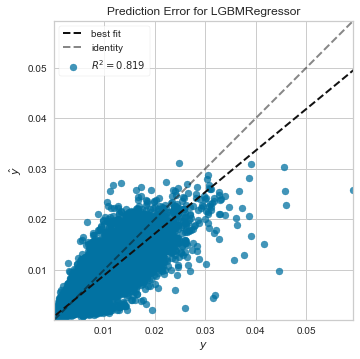

In [156] used 0.0586 MiB RAM in 1.61s, peaked 0.00 MiB above current, total RAM usage 3722.59 MiB


In [156]:
try:
    if X_test.shape[0] > 0:
        from yellowbrick.regressor import PredictionError
        visualizer = PredictionError(est)
        visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
        visualizer.score(X_test, y_test)  # Evaluate the model on the test data
        ax_subplot = visualizer.show()        
except ModuleNotFoundError:
    print('no yellowbrick')

In [157]:
if ENV_HOME:
    import eli5
    display(eli5.show_weights(est, feature_names=feature_cols, top=10))

Weight,Feature
0.7113,log_return1_linear
0.1603,log_return1_uniform
0.0770,log_return2_linear
0.0142,log_return2_uniform
0.0057,size
0.0047,stock_id
0.0036,log_return2_half0half1
0.0031,log_return1_half0half1
0.0023,ask_price2_var
0.0019,ask_size1_mean


In [157] used 0.0078 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 3722.60 MiB


In [158]:
if 'feature_importances_' in dir(est):
    feature_col = 'feature_importances_'
elif 'coef_' in dir(est):
    feature_col = 'coef_'
df_features = pd.DataFrame(zip(getattr(est, feature_col), feature_cols), columns=['importance', 'feature']).set_index('importance')
df_features.sort_index(ascending=False)

,feature
importance,
351,size
317,stock_id
190,log_return1_uniform
188,log_return2_linear
170,log_return1_linear
139,bid_size2_mean
133,bid_size1_mean
130,ask_size1_mean
126,ask_size2_mean


In [158] used 0.0000 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 3722.60 MiB


# Make predictions

In [159]:
len(stock_ids) # expecting 112

112

In [159] used 0.0000 MiB RAM in 0.11s, peaked 0.02 MiB above current, total RAM usage 3722.60 MiB


In [160]:
if USE_TEST_LOCAL_6_ITEMS: # True if debugging
    # book train as a substitute
    df_test_all = pd.read_csv(os.path.join(ROOT, 'test_local.csv'))
    df_test_all = df_test_all.rename(columns={'target': 'train_target'})
    TEST_FOLDER = 'book_test_local.parquet'
    assert ENV_HOME == True
else:
    df_test_all = pd.read_csv(TEST_CSV)
    if df_test_all.shape[0] == 3: # kaggle test data
        df_test_all = df_test_all[:1] # cut out 2 rows so predictions work    
    TEST_FOLDER = 'book_test.parquet'
print(ROOT, TEST_FOLDER)
df_test_all = df_test_all.set_index(['stock_id', 'time_id'])

show_details(df_test_all)

/home/ian/data/kaggle/optiver_volatility/ book_test_local.parquet
[2c] 22,980x2, 0 nulls, is_view True, is_single_block True, is_consolidated True
In [160] used 0.0078 MiB RAM in 0.15s, peaked 0.00 MiB above current, total RAM usage 3722.61 MiB


In [161]:
test_set_predictions = []
stock_ids_test = get_training_stock_ids(TEST_FOLDER) # all stocks by default

df_test_predictions = pd.DataFrame() # prediction set to build up
for stock_id in tqdm(stock_ids_test):
    df_test_all_X = df_test_all.query('stock_id==@stock_id').copy()
    test_merged = load_data_build_features(stock_id, ROOT, TEST_FOLDER, cols, df_test_all)
    test_set_predictions_X = est.predict(test_merged.reset_index()[list(features) + ['stock_id']])
    df_test_all_X['target'] = test_set_predictions_X
    df_test_predictions = pd.concat((df_test_predictions, df_test_all_X))
    
assert df_test_all.shape[0] == df_test_predictions.shape[0], "Expecting all rows to be predicted"

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:43<00:00, 17.26s/it]

In [161] used 8.7695 MiB RAM in 103.65s, peaked 561.89 MiB above current, total RAM usage 3731.38 MiB


In [162]:
print(f"Writing {df_test_predictions.shape[0]} rows to submission.csv on {datetime.datetime.utcnow()}")
df_test_predictions.reset_index()[['row_id', 'target']].to_csv('submission.csv', index=False)
show_details(df_test_predictions)
print(f'Notebook took {datetime.datetime.utcnow()-t1_notebook_start} to run')

Writing 22980 rows to submission.csv on 2021-08-20 20:19:35.986159
[2c] 22,980x3, 0 nulls, is_view True, is_single_block True, is_consolidated True
Notebook took 0:08:56.598177 to run
In [162] used 0.0000 MiB RAM in 0.18s, peaked 0.00 MiB above current, total RAM usage 3731.38 MiB


In [163]:
if not ENV_HOME:
    assert USE_ALL_STOCK_IDS, "If we're on Kaggle but not using all stock_ids, we're not ready to submit, so fail here to remind me to change USSE_ALL_STOCK_IDS!"

In [163] used 0.0312 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 3731.41 MiB
